In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
from shapely.wkt import loads
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from kneed import KneeLocator
import re
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
file_path = "/content/drive/MyDrive/EV dataset/Electric_Vehicle_Charging_Stations.csv"
ev_station_df = pd.read_csv(file_path)


In [ ]:
ev_station_df

,Station Name,Street Address,City,Access Days Time,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Other Info,New Georeferenced Column
0,BMW OF DARIEN,138-142 Ledge Rd,Darien,24 hours daily,NONE,2,NONE,NONE,POINT (-73.4764687 41.072882)
1,Dunkin’ - Tesla Supercharger,893 E Main St,Meriden,24 hours daily; for Tesla use only,NONE,NONE,8,NONE,POINT (-72.773473 41.527367)
2,Town of Beacon Falls - Commuter Lot,105 N Main St,Beacon Falls,24 hours daily,NONE,1,NONE,NONE,POINT (-73.065583 41.44548100000001)
3,OLD SAYBROOK VW,319 Middlesex Turnpike,Old Saybrook,24 hours daily,NONE,2,NONE,NONE,POINT (-72.3825 41.3102778)
4,Fairfield Rail Station,80 Mill Plain Rd,Fairfield,24 hours daily,NONE,2,NONE,NONE,POINT (-73.264511 41.143125)
...,...,...,...,...,...,...,...,...,...
380,Lee Partyka Chevrolet Mazda Isuzu,200 Skiff St,Hamden,Dealership business hours,NONE,3,NONE,NONE,POINT (-72.9100121 41.3729709)
381,777 MAIN ST,71 Asylum St,Hartford,24 hours daily,NONE,10,1,NONE,POINT (-72.674468 41.766676)
382,Norwich Public Utilities,173 N Main St,Norwich,24 hours daily,NONE,4,NONE,NONE,POINT (-72.063516 41.52757900000001)
383,Fairfield Plaza,116 Danbury Rd,New Milford,24 hours daily,NONE,NONE,1,NONE,POINT (-73.41763 41.55735)


In [ ]:
# Check for null or missing values
print(ev_station_df.isnull().sum())

Station Name                0
Street Address              0
City                        0
Access Days Time            0
EV Level1 EVSE Num          0
EV Level2 EVSE Num          0
EV DC Fast Count            0
EV Other Info               0
New Georeferenced Column    0
dtype: int64


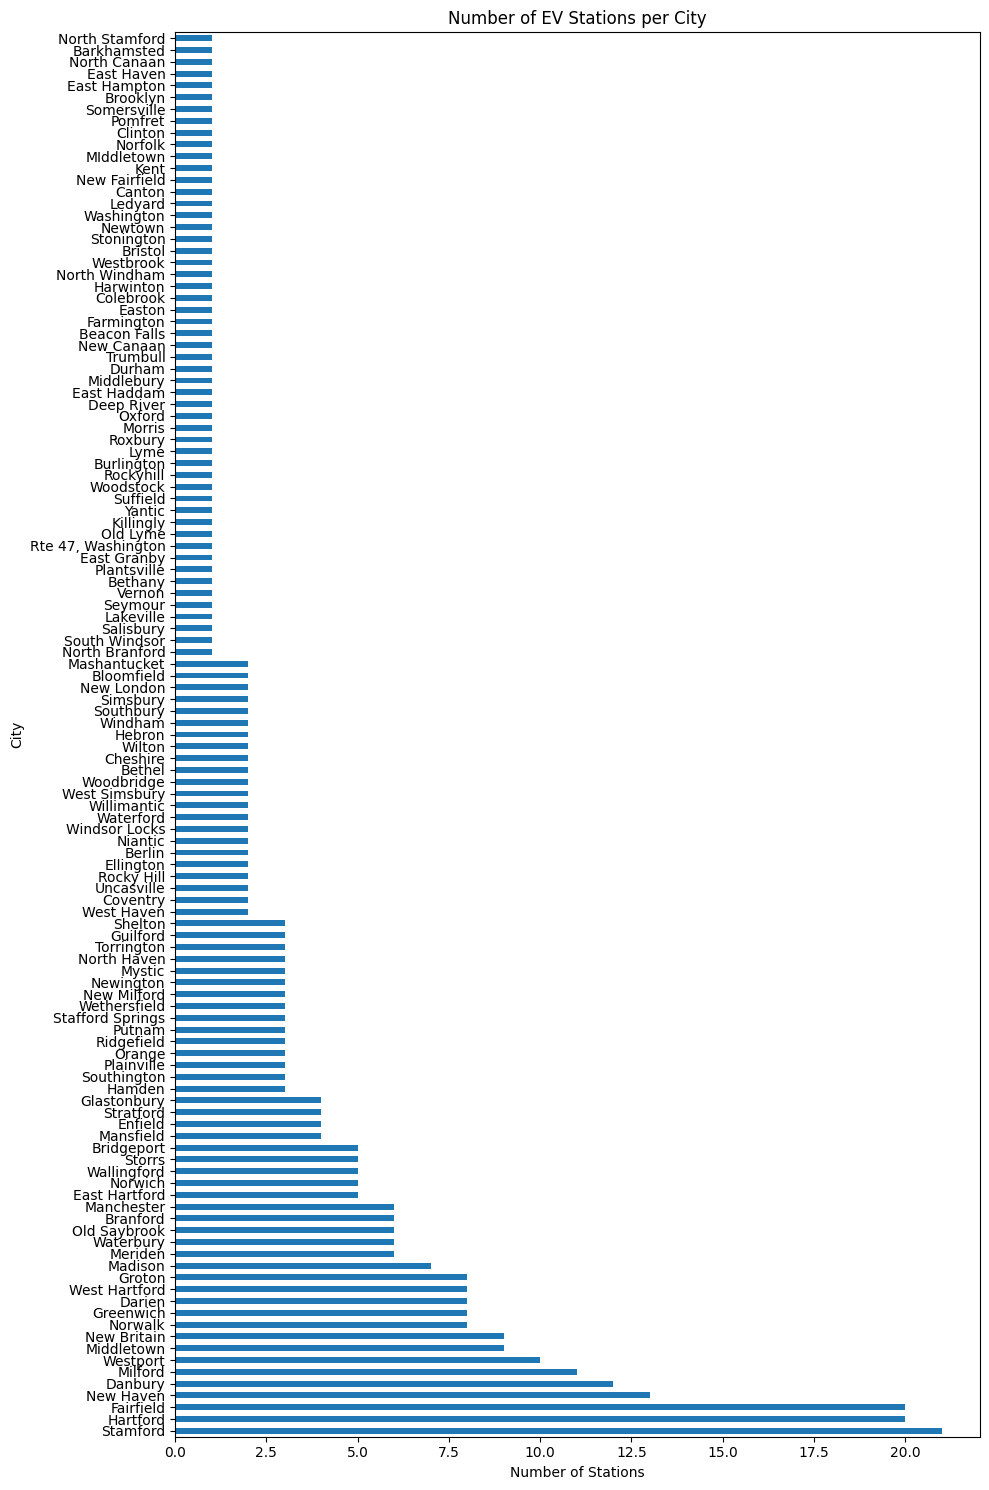

In [ ]:
# Count the number of stations per city
city_counts = ev_station_df['City'].value_counts()
# Create a horizontal bar plot
plt.figure(figsize=(10, 15))
city_counts.plot(kind='barh') # Changed to 'barh' for horizontal bars
plt.title('Number of EV Stations per City')
plt.xlabel('Number of Stations')
plt.ylabel('City')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze the distribution of EV chargers
level1_count = ev_station_df["EV Level1 EVSE Num"].notna().sum()
level2_count = ev_station_df["EV Level2 EVSE Num"].notna().sum()
dc_fast_count = ev_station_df["EV DC Fast Count"].notna().sum()

print(f"Level 1 Chargers: {level1_count}")
print(f"Level 2 Chargers: {level2_count}")
print(f"DC Fast Chargers: {dc_fast_count}")


Level 1 Chargers: 385
Level 2 Chargers: 385
DC Fast Chargers: 385


In [ ]:
# Convert 'New Georeferenced Column' to separate latitude and longitude columns

# Convert the georeferenced column to Shapely Points and extract coordinates
ev_station_df['Coordinates'] = ev_station_df['New Georeferenced Column'].apply(loads)
ev_station_df['Latitude'] = ev_station_df['Coordinates'].apply(lambda point: point.y)
ev_station_df['Longitude'] = ev_station_df['Coordinates'].apply(lambda point: point.x)

print(ev_station_df[['Station Name', 'Latitude', 'Longitude']].head())


                          Station Name   Latitude  Longitude
0                        BMW OF DARIEN  41.072882 -73.476469
1         Dunkin’ - Tesla Supercharger  41.527367 -72.773473
2  Town of Beacon Falls - Commuter Lot  41.445481 -73.065583
3                      OLD SAYBROOK VW  41.310278 -72.382500
4               Fairfield Rail Station  41.143125 -73.264511


In [ ]:
# Initialize a Folium map centered around the USA
usa_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5, tiles='OpenStreetMap')

# Add charging station markers to the map
for _, row in ev_station_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"Station Name: {row['Station Name']}<br>"
            f"City: {row['City']}<br>"
            f"Access: {row['Access Days Time']}<br>"
            f"Level 1 Chargers: {row['EV Level1 EVSE Num']}<br>"
            f"Level 2 Chargers: {row['EV Level2 EVSE Num']}<br>"
            f"DC Fast Chargers: {row['EV DC Fast Count']}"
        ),
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(usa_map)


usa_map


In [ ]:
# Function to clean 'NONE' and extract numeric values
def clean_and_convert(value):
    if isinstance(value, str):
        # Remove 'NONE' patterns while preserving numbers
        cleaned_value = re.sub(r'NONE', '', value)  # Remove 'NONE'
        if cleaned_value.isdigit():  # Check if only digits remain
            return int(cleaned_value)
        else:
            return 0  # Default to 0 if no digits remain
    elif isinstance(value, (int, float)):  # If already numeric
        return value
    else:
        return 0  # Default to 0 for non-numeric or empty values

# List of columns to clean and convert
columns_to_clean = ['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']

# Apply cleaning and convert to numeric
for column in columns_to_clean:
    ev_station_df[column] = ev_station_df[column].apply(clean_and_convert).astype(int)



In [ ]:
# Aggregate data by City to calculate charger density
city_charger_data = ev_station_df.groupby('City', as_index=False).agg({
    'EV Level1 EVSE Num': 'sum',
    'EV Level2 EVSE Num': 'sum',
    'EV DC Fast Count': 'sum',
    'Station Name': 'count',  # Count number of stations in each city
})

# Rename columns for clarity
city_charger_data.rename(columns={
    'Station Name': 'Station Count',
    'EV Level1 EVSE Num': 'Level1 Chargers',
    'EV Level2 EVSE Num': 'Level2 Chargers',
    'EV DC Fast Count': 'DC Fast Chargers'
}, inplace=True)



In [ ]:
city_charger_data

,City,Level1 Chargers,Level2 Chargers,DC Fast Chargers,Station Count
0,Barkhamsted,0,2,0,1
1,Beacon Falls,0,1,0,1
2,Berlin,0,6,0,2
3,Bethany,0,2,0,1
4,Bethel,0,4,0,2
...,...,...,...,...,...
114,Windham,0,4,0,2
115,Windsor Locks,0,6,0,2
116,Woodbridge,0,4,0,2
117,Woodstock,1,1,0,1


In [ ]:
# Select features for clustering
features = ['Level1 Chargers', 'Level2 Chargers', 'DC Fast Chargers', 'Station Count']

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(city_charger_data[features])


# K-Means

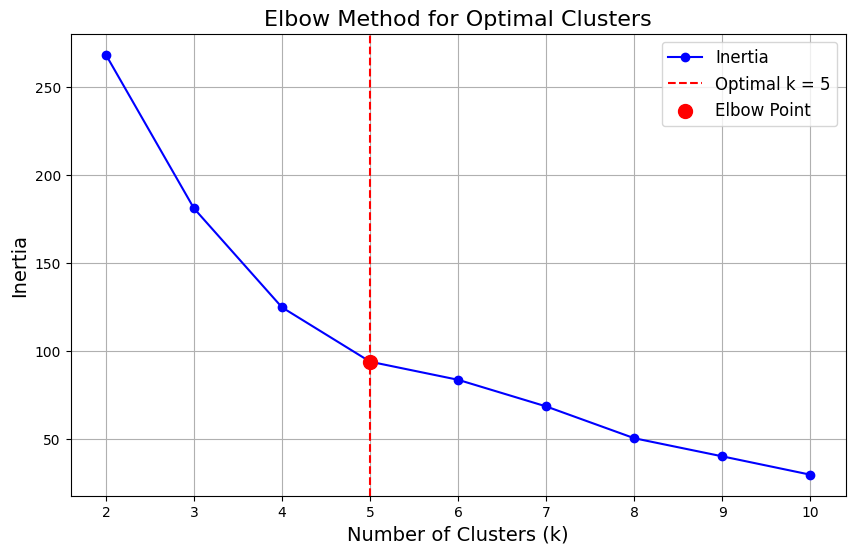

The optimal number of clusters (k) is: 5


In [ ]:
# Calculate inertia for different numbers of clusters
inertia = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Automatically determine the optimal k using the "knee point" method
knee_locator = KneeLocator(cluster_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Plot the Elbow Method with automatic detection of optimal k
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', label='Inertia', color='b')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.scatter(optimal_k, inertia[optimal_k - 2], color='red', s=100, zorder=5, label='Elbow Point')  # Highlight the elbow
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(cluster_range)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print(f"The optimal number of clusters (k) is: {optimal_k}")


In [ ]:
# Fit K-Means with the chosen number of clusters
optimal_k = 5  # Based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
city_charger_data['Cluster'] = kmeans.fit_predict(scaled_data)


In [ ]:
city_charger_data

,City,Level1 Chargers,Level2 Chargers,DC Fast Chargers,Station Count,Cluster
0,Barkhamsted,0,2,0,1,1
1,Beacon Falls,0,1,0,1,1
2,Berlin,0,6,0,2,1
3,Bethany,0,2,0,1,1
4,Bethel,0,4,0,2,1
...,...,...,...,...,...,...
114,Windham,0,4,0,2,1
115,Windsor Locks,0,6,0,2,1
116,Woodbridge,0,4,0,2,1
117,Woodstock,1,1,0,1,1


In [ ]:
# Group data by clusters and calculate summary statistics
cluster_summary = city_charger_data.groupby('Cluster').agg({
    'Level1 Chargers': ['mean', 'median', 'sum'],
    'Level2 Chargers': ['mean', 'median', 'sum'],
    'DC Fast Chargers': ['mean', 'median', 'sum'],
    'Station Count': ['mean', 'median', 'sum']
})

cluster_summary

Level1 Chargers            Level2 Chargers              \
                   mean median sum            mean median  sum   
Cluster                                                          
0              0.000000    0.0   0       13.250000   14.0   53   
1              0.041237    0.0   4        3.391753    2.0  329   
2              6.000000    6.0  12        4.000000    4.0    8   
3              0.333333    0.0   1       53.666667   63.0  161   
4              0.307692    0.0   4       17.923077   14.0  233   

        DC Fast Chargers            Station Count              
                    mean median sum          mean median  sum  
Cluster                                                        
0              18.000000   19.0  72      9.000000    9.0   36  
1               0.515464    0.0  50      1.814433    1.0  176  
2              14.000000   14.0  28      5.000000    5.0   10  
3              14.333333   13.0  43     20.333333   20.0   61  
4               2.846154    1.0  37      7.846154    8.0  102

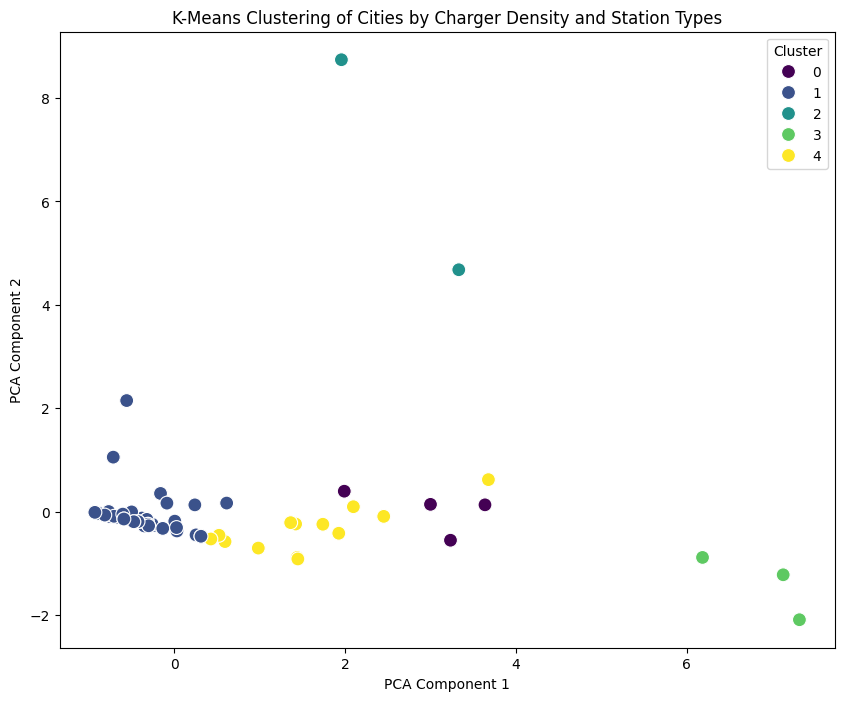

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
city_charger_data['PCA1'] = reduced_data[:, 0]
city_charger_data['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=city_charger_data, palette='viridis', s=100
)
plt.title('K-Means Clustering of Cities by Charger Density and Station Types')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Add Latitude and Longitude of cities for mapping
city_location_data = ev_station_df.groupby('City', as_index=False).agg({
    'Latitude': 'mean',
    'Longitude': 'mean'
})

# Merge with clustering results
city_charger_map_data = city_charger_data.merge(city_location_data, on='City')

# Create the map
city_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add city markers
colors = ['blue', 'green', 'orange', 'purple', 'red']
for _, row in city_charger_map_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"City: {row['City']}<br>"
            f"Cluster: {row['Cluster']}<br>"
            f"Level 1 Chargers: {row['Level1 Chargers']}<br>"
            f"Level 2 Chargers: {row['Level2 Chargers']}<br>"
            f"DC Fast Chargers: {row['DC Fast Chargers']}<br>"
            f"Station Count: {row['Station Count']}"
        ),
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)])
    ).add_to(city_map)

city_map

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

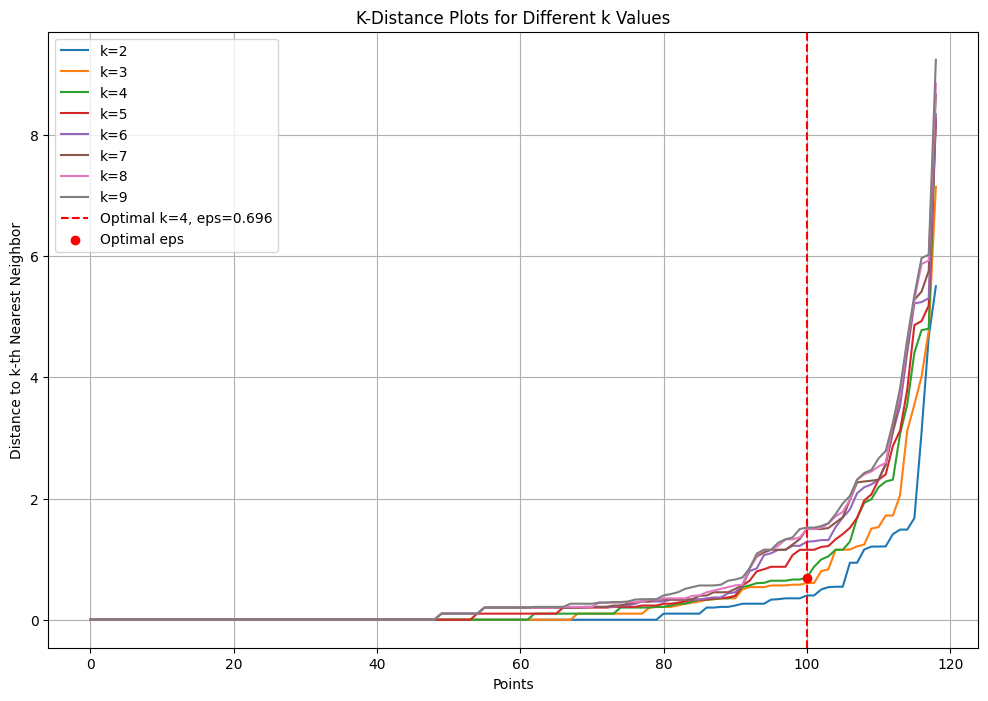

Optimal k: 4
Optimal eps: 0.696

All Knee Points Detected (k, knee index, eps):
k=2, Knee Index=111, eps=1.2109113508096467
k=3, Knee Index=108, eps=1.2401121558153154
k=4, Knee Index=100, eps=0.6963724546008923
k=5, Knee Index=103, eps=1.2159316110317333
k=6, Knee Index=103, eps=1.3141297057008081
k=7, Knee Index=110, eps=2.3110073687710804
k=8, Knee Index=103, eps=1.5852363690873545
k=9, Knee Index=103, eps=1.5936363356579217


In [ ]:
def find_and_plot_optimal_k(data, k_range):
    best_k = None
    best_eps = None
    best_knee_index = None
    all_knees = []

    plt.figure(figsize=(12, 8))

    # Iterate through the range of `k` values
    for k in k_range:
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(data)
        distances, _ = neighbors_fit.kneighbors(data)
        distances = np.sort(distances[:, k - 1])  # Sort distances for k-th nearest neighbor

        # Use KneeLocator to find the elbow
        knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
        all_knees.append((k, knee.knee, distances[knee.knee] if knee.knee is not None else None))

        # Plot k-distance curve
        plt.plot(distances, label=f'k={k}')

        # Track the best `k` if a knee point exists
        if knee.knee is not None:
            if best_knee_index is None or knee.knee < best_knee_index:
                best_k = k
                best_eps = distances[knee.knee]
                best_knee_index = knee.knee

    # Highlight the optimal `k` and its elbow
    if best_k is not None:
        plt.axvline(x=best_knee_index, color='r', linestyle='--', label=f'Optimal k={best_k}, eps={best_eps:.3f}')
        plt.scatter([best_knee_index], [best_eps], color='red', zorder=5, label='Optimal eps')

    plt.title('K-Distance Plots for Different k Values')
    plt.xlabel('Points')
    plt.ylabel('Distance to k-th Nearest Neighbor')
    plt.legend()
    plt.grid()
    plt.show()

    # Print the results
    print(f"Optimal k: {best_k}")
    print(f"Optimal eps: {best_eps:.3f}")
    print("\nAll Knee Points Detected (k, knee index, eps):")
    for knee_data in all_knees:
        print(f"k={knee_data[0]}, Knee Index={knee_data[1]}, eps={knee_data[2]}")

    return best_k, best_eps

# Define a range of `k` values to test
k_range = range(2, 10)

# Find and visualize the optimal `k`
optimal_k, optimal_eps = find_and_plot_optimal_k(scaled_data, k_range)


In [ ]:
# For DBSCAN (using eps and min_samples)
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_k)
city_charger_data['Cluster'] = dbscan.fit_predict(scaled_data)


In [ ]:
# Step 2: Analyze Clusters with Summary Statistics
cluster_summary = city_charger_data.groupby('Cluster').agg({
    'Level1 Chargers': ['mean', 'median', 'sum'],
    'Level2 Chargers': ['mean', 'median', 'sum'],
    'DC Fast Chargers': ['mean', 'median', 'sum'],
    'Station Count': ['mean', 'median', 'sum']
})
cluster_summary

Level1 Chargers            Level2 Chargers              \
                   mean median sum            mean median  sum   
Cluster                                                          
-1               1.3125    1.0  21        21.00000   18.0  336   
 0               0.0000    0.0   0         4.12766    3.0  388   
 1               0.0000    0.0   0        13.00000   12.5   52   
 2               0.0000    0.0   0         1.60000    2.0    8   

        DC Fast Chargers             Station Count              
                    mean median  sum          mean median  sum  
Cluster                                                         
-1              9.125000    8.5  146      9.375000    8.5  150  
 0              0.138298    0.0   13      2.085106    1.0  196  
 1              8.250000    8.0   33      7.000000    7.0   28  
 2              7.600000    8.0   38      2.200000    2.0   11

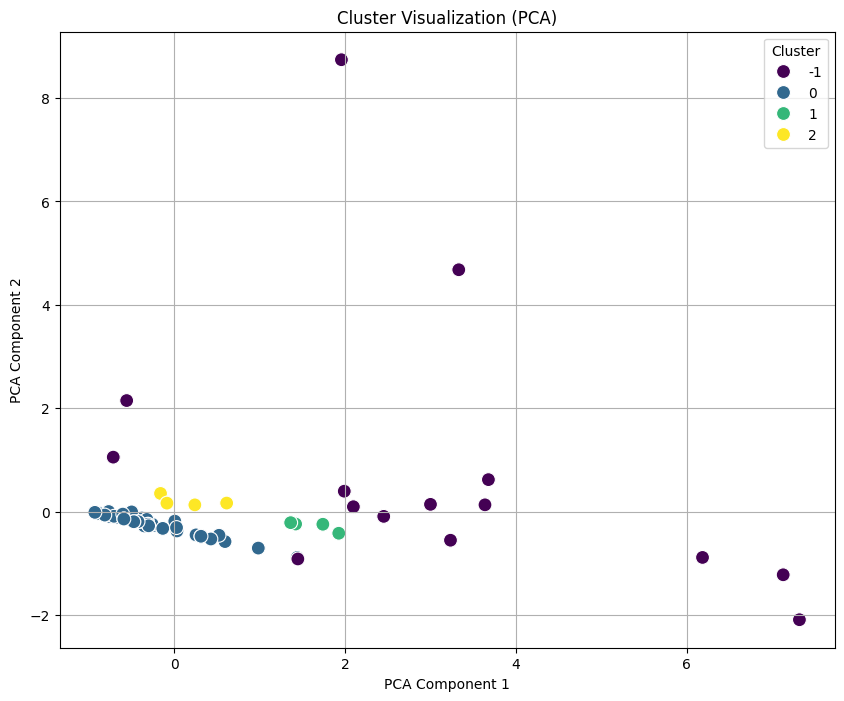

In [ ]:
# Reduce Dimensions with PCA for Visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
city_charger_data['PCA1'] = reduced_data[:, 0]
city_charger_data['PCA2'] = reduced_data[:, 1]

# Plot Clusters on PCA Components
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=city_charger_data, palette='viridis', s=100
)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


In [ ]:
# Add Location Data for Mapping (Latitude and Longitude)
# Assuming `ev_station_df` contains location data (Latitude, Longitude, City)
city_location_data = ev_station_df.groupby('City', as_index=False).agg({
    'Latitude': 'mean',
    'Longitude': 'mean'
})
city_charger_map_data = city_charger_data.merge(city_location_data, on='City')


In [ ]:
# Visualize Clusters on a Map using Folium
city_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # Adjust starting location and zoom
colors = ['blue', 'green', 'orange', 'purple', 'red', 'darkblue', 'darkgreen']

for _, row in city_charger_map_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"City: {row['City']}<br>"
            f"Cluster: {row['Cluster']}<br>"
            f"Level 1 Chargers: {row['Level1 Chargers']}<br>"
            f"Level 2 Chargers: {row['Level2 Chargers']}<br>"
            f"DC Fast Chargers: {row['DC Fast Chargers']}<br>"
            f"Station Count: {row['Station Count']}"
        ),
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)])
    ).add_to(city_map)

# Display the map
city_map


# Agglomerative Hierarchical Clustering (Agglomerative Clustering)


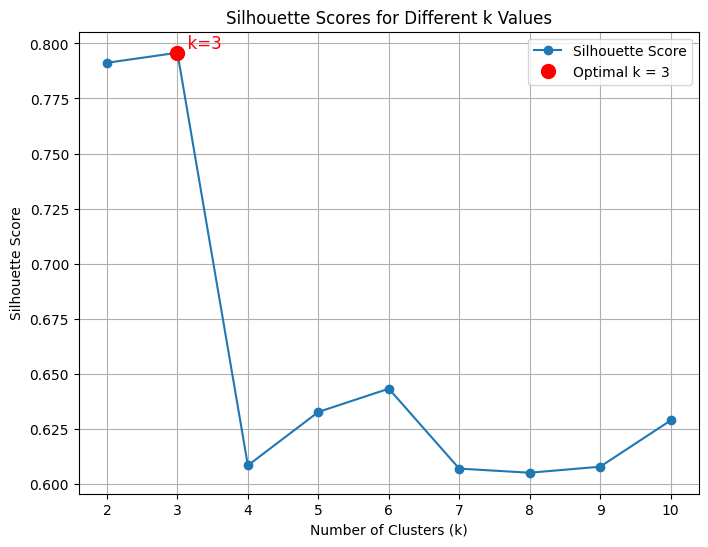

The optimal k based on silhouette score is: 3


In [ ]:
# Define a range of k values to test
k_range = range(2, 11)  # Test k values from 2 to 10

# Store silhouette scores for each k
silhouette_scores = []

# Iterate through the range of k values
for k in k_range:
    # Initialize Agglomerative Clustering with the given k
    agg_clust = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Fit the model and predict cluster labels
    cluster_labels = agg_clust.fit_predict(scaled_data)

    # Calculate silhouette score
    score = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores for each k
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Find the optimal k with the highest silhouette score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
optimal_score = max(silhouette_scores)

# Highlight the optimal k on the plot
plt.plot(optimal_k, optimal_score, 'ro', markersize=10, label=f'Optimal k = {optimal_k}')

# Annotate the point
plt.text(optimal_k, optimal_score, f'  k={optimal_k}', color='red', fontsize=12, verticalalignment='bottom')

# Display grid and legend
plt.grid()
plt.legend()
plt.show()

print(f"The optimal k based on silhouette score is: {optimal_k}")


In [ ]:
# Perform Agglomerative Clustering with the optimal number of clusters (from previous analysis)
agg_clust = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
city_charger_data['Cluster'] = agg_clust.fit_predict(scaled_data)

# Step 1: Analyze Clusters with Summary Statistics
cluster_summary = city_charger_data.groupby('Cluster').agg({
    'Level1 Chargers': ['mean', 'median', 'sum'],
    'Level2 Chargers': ['mean', 'median', 'sum'],
    'DC Fast Chargers': ['mean', 'median', 'sum'],
    'Station Count': ['mean', 'median', 'sum']
})
cluster_summary


Level1 Chargers            Level2 Chargers              \
                   mean median sum            mean median  sum   
Cluster                                                          
0              0.070175    0.0   8        5.394737    3.0  615   
1              6.000000    6.0  12        4.000000    4.0    8   
2              0.333333    0.0   1       53.666667   63.0  161   

        DC Fast Chargers             Station Count              
                    mean median  sum          mean median  sum  
Cluster                                                         
0               1.394737    0.0  159      2.754386    2.0  314  
1              14.000000   14.0   28      5.000000    5.0   10  
2              14.333333   13.0   43     20.333333   20.0   61

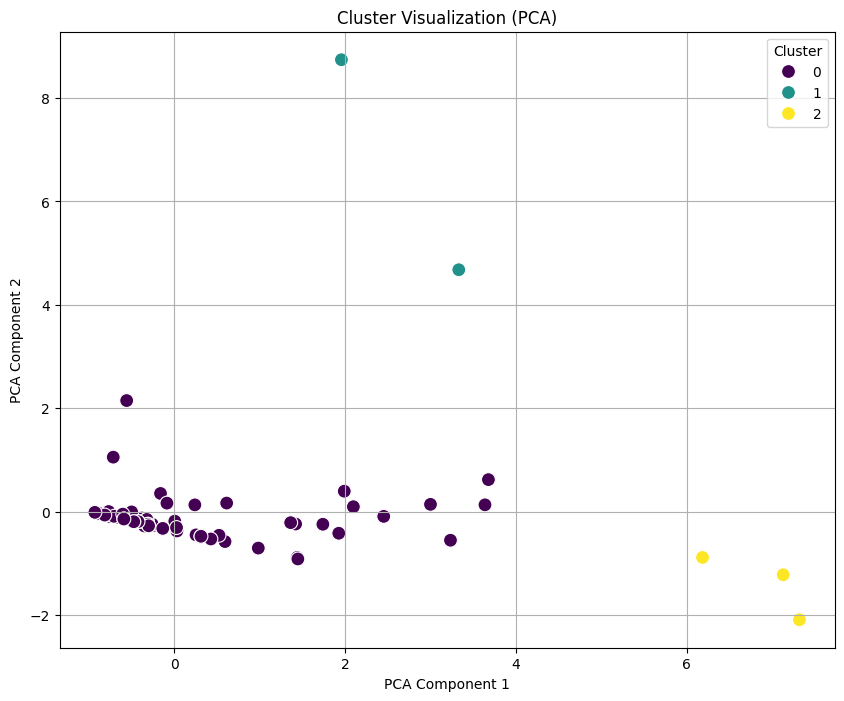

In [ ]:
# Reduce Dimensions with PCA for Visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
city_charger_data['PCA1'] = reduced_data[:, 0]
city_charger_data['PCA2'] = reduced_data[:, 1]

# Plot Clusters on PCA Components
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=city_charger_data, palette='viridis', s=100
)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


In [ ]:
# Add Location Data for Mapping (Latitude and Longitude)
# Assuming `ev_station_df` contains location data (Latitude, Longitude, City)
city_location_data = ev_station_df.groupby('City', as_index=False).agg({
    'Latitude': 'mean',
    'Longitude': 'mean'
})
city_charger_map_data = city_charger_data.merge(city_location_data, on='City')

# Visualize Clusters on a Map using Folium
city_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # Adjust starting location and zoom
colors = ['blue', 'green', 'orange', 'purple', 'red', 'darkblue', 'darkgreen']

for _, row in city_charger_map_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"City: {row['City']}<br>"
            f"Cluster: {row['Cluster']}<br>"
            f"Level 1 Chargers: {row['Level1 Chargers']}<br>"
            f"Level 2 Chargers: {row['Level2 Chargers']}<br>"
            f"DC Fast Chargers: {row['DC Fast Chargers']}<br>"
            f"Station Count: {row['Station Count']}"
        ),
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)])
    ).add_to(city_map)

# Display the map
city_map
